This test will be testing standard gradient descent against Moore-Penrose inversion for finding the parameters of a single linear layer. This linear layer cannot have any activation function since it must remain a pure linear but can have a bias. The bias will be implemented by appending a single 1.0 to the input vector.

In [18]:
import numpy as np
import matplotlib.pyplot as plt

The test dataset will require the model to do a simple linear separation. To generate, first randomly sample 2D points and then label them -1 if they are below a line or 1 if above. To quickly visualize the points and their labels, plot for each line the points for each label. To visualize the decision spaces, create an array of all points (with specific resolution) within a square, predict them all, then resize and display as an image for each line.

In [19]:
def generate_dataset(num_samples, limits, label_functions):
    points = np.random.uniform(*limits, (num_samples, 2))
    labels = np.array([label_func(*points.T) for label_func in label_functions]).T
    return points, labels


def plot_points(points, labels):
    # Get the number of points (s) and the number of label sets (l)
    s, l = labels.shape

    # --- Create a dynamic grid for the subplots ---
    # This makes the plot layout look good even with many label sets.
    if l == 1:
        nrows, ncols = 1, 1
    else:
        # Calculate a squarish grid layout
        nrows = int(np.sqrt(l))
        ncols = int(np.ceil(l / nrows))

    # Create the figure and axes objects
    # The figsize is adjusted based on the number of columns and rows
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5), squeeze=False)

    # Flatten the axes array to make it easy to iterate over, regardless of grid shape
    axes = axes.flatten()

    # --- Iterate over each label set and create a subplot ---
    for i in range(l):
        ax = axes[i]
        current_labels = labels[:, i]

        # Create boolean masks to filter points based on label values
        non_negative_mask = current_labels >= 0
        negative_mask = current_labels < 0

        # Plot points with non-negative labels (e.g., in blue)
        ax.scatter(
            points[non_negative_mask, 0],
            points[non_negative_mask, 1],
            color='blue',
            label='Label >= 0',
            alpha=0.7
        )

        # Plot points with negative labels (e.g., in red)
        ax.scatter(
            points[negative_mask, 0],
            points[negative_mask, 1],
            color='red',
            label='Label < 0',
            alpha=0.7
        )

        # --- Set subplot titles and labels for clarity ---
        ax.set_title(f'Visualization for Label Set {i}')
        ax.set_xlabel('X-coordinate')
        ax.set_ylabel('Y-coordinate')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    # --- Clean up the layout ---
    # Hide any unused subplots if l is not a perfect square
    for i in range(l, len(axes)):
        axes[i].set_visible(False)

    # Adjust layout to prevent titles and labels from overlapping
    plt.tight_layout()
    plt.show()


def plot_space(W, width=10, res=100, bias=True):
    values = np.linspace(0, width, res)
    indices = np.indices((res, res)).reshape(2, -1).T
    X = values[indices]
    Y = pred(W, X, bias)

    s, l = Y.shape

    # --- Create a dynamic grid for the subplots ---
    # This makes the plot layout look good even with many label sets.
    if l == 1:
        nrows, ncols = 1, 1
    else:
        # Calculate a squarish grid layout
        nrows = int(np.sqrt(l))
        ncols = int(np.ceil(l / nrows))

    # Create the figure and axes objects
    # The figsize is adjusted based on the number of columns and rows
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5), squeeze=False)

    # Flatten the axes array to make it easy to iterate over, regardless of grid shape
    axes = axes.flatten()

    # --- Iterate over each label set and create a subplot ---
    for i in range(l):
        ax = axes[i]

        ax.imshow(Y[:, i].reshape(res, res).T, origin="lower")

        # --- Set subplot titles and labels for clarity ---
        ax.set_title(f'Visualization for Label Set {i}')
        ax.set_xlabel('X-coordinate')
        ax.set_ylabel('Y-coordinate')
        ax.grid(True, linestyle='--', alpha=0.6)

    # --- Clean up the layout ---
    # Hide any unused subplots if l is not a perfect square
    for i in range(l, len(axes)):
        axes[i].set_visible(False)

    # Adjust layout to prevent titles and labels from overlapping
    plt.tight_layout()
    plt.show()


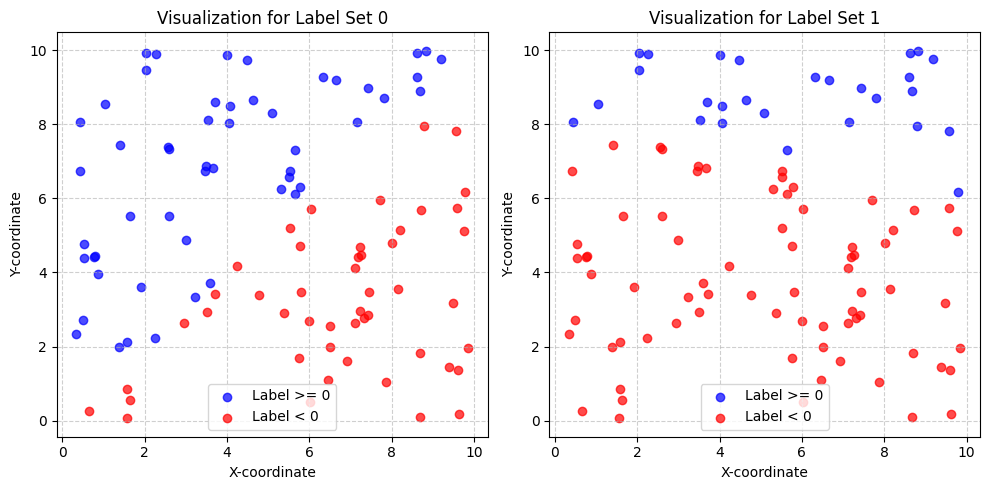

In [20]:
points, labels = generate_dataset(100, (0, 10), [
    lambda x, y: (y > x) * 2 - 1,
    lambda x, y: (y > -0.2 * x + 8) * 2 - 1,
])
plot_points(points, labels)

Define the pseudoinverse fitting function it just takes in X and Y and then returns W = (X.T @ X)^(-1) @ (X.T @ Y). Define forward pass as Y = W @ X and append 1 to the datapoints in X for bias.

In [21]:
def pred(W, X, bias=True):
    if bias:
        X = np.concatenate((X, np.full(X.shape[:-1] + (1,), 1)), axis=-1)
    return (X @ W.T)


def mpi_fit(X, Y, A=0, B=0, bias=True):
    if bias:
        X = np.concatenate((X, np.full(X.shape[:-1] + (1,), 1)), axis=-1)

    A += X.T @ X
    B += X.T @ Y
    W = (np.linalg.inv(A) @ (B)).T
    if bias:
        loss = np.mean((Y - pred(W, X[..., :-1])) ** 2)
    else:
        loss = np.mean((Y - pred(W, X, bias=False)) ** 2)
        
    return W, loss, A, B


def get_grad(W, X, Y):
    error = Y - pred(W, X[..., :-1])
    dW = (error.T @ X) / len(X)
    return dW, np.mean(error ** 2)


def gd_fit(X, Y, epochs=10, lr=0.1, W=None):
    X = np.concatenate((X, np.full(X.shape[:-1] + (1,), 1)), axis=-1)

    if W is None:
        W = np.random.randn(Y.shape[1], X.shape[1])

    losses = np.zeros(epochs)
    for epoch in range(epochs):
        dW, losses[epoch] = get_grad(W, X, Y)
        W += dW * lr
    return W, losses

Fit some weights using MPI and GD, get their predictions, then plot the points classification and plot the decision spaces.

Moore Penrose loss: 0.31
Gradient Descent loss: 0.39


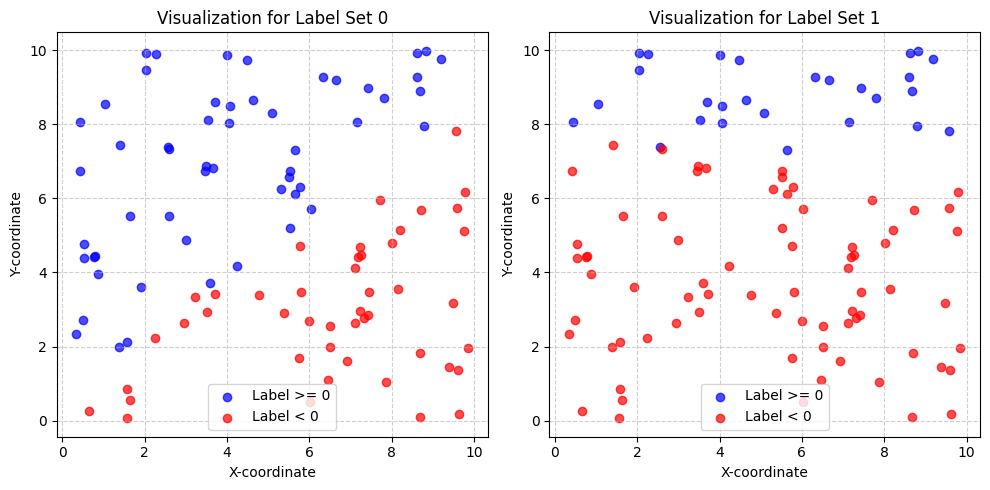

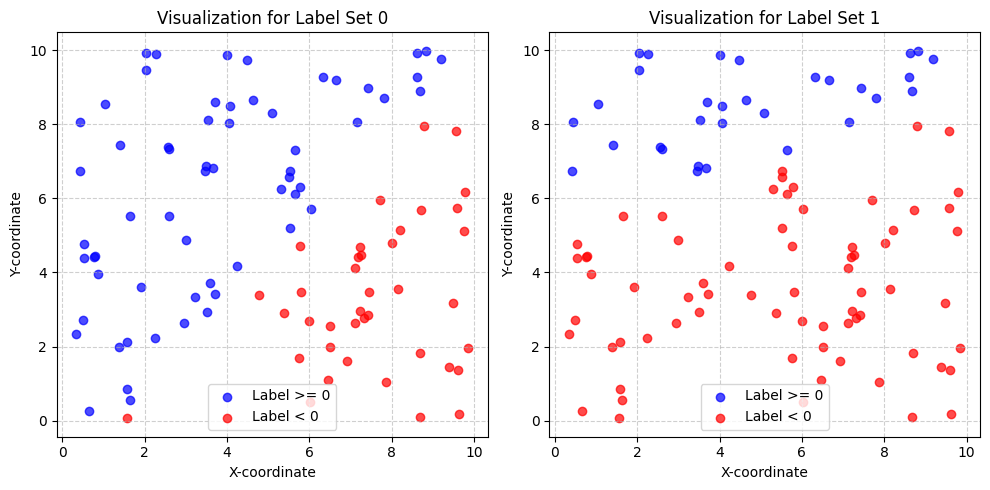

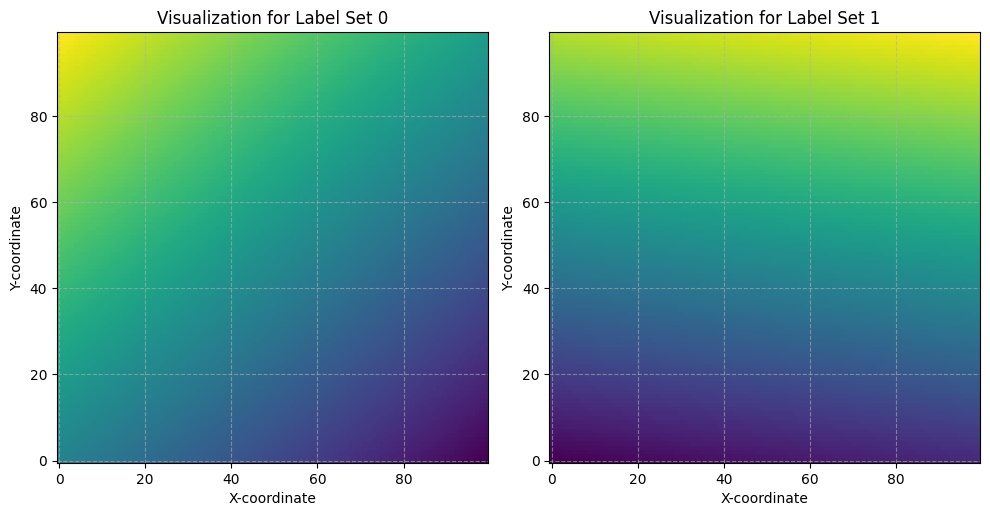

KeyboardInterrupt: 

In [22]:
mpi_W, loss, _, _ = mpi_fit(points, labels)
gd_W, losses = gd_fit(points, labels, 1000, 0.01)
print(f"Moore Penrose loss: {loss:.2f}\nGradient Descent loss: {losses[-1]:.2f}")

mpi_Y = pred(mpi_W, points)
gd_Y = pred(gd_W, points)

plot_points(points, mpi_Y)
plot_points(points, gd_Y)

plot_space(mpi_W, 10, 100)
plot_space(gd_W, 10, 100)

Display loss graph for gradient descent and show that it's above the loss of the MPI optimization.

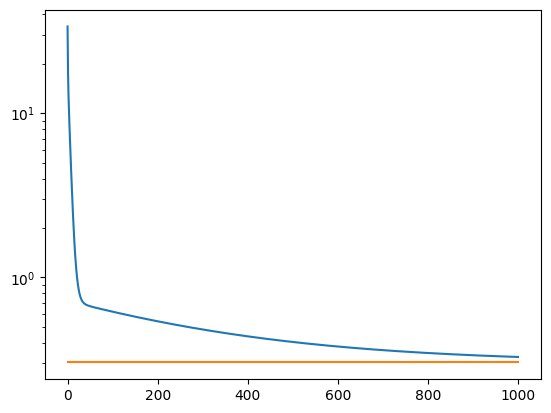

In [ ]:
plt.plot(losses)
plt.plot([0, len(losses)], [loss, loss])
plt.yscale('log', base=10)
plt.show()

Try training the network in sequence, first for one separation then for the second separation. Then compare the total losses of the two models and their predictions like before. First the two datasets need to be generated.

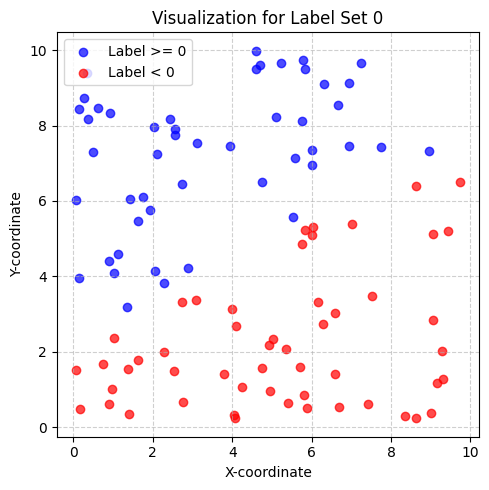

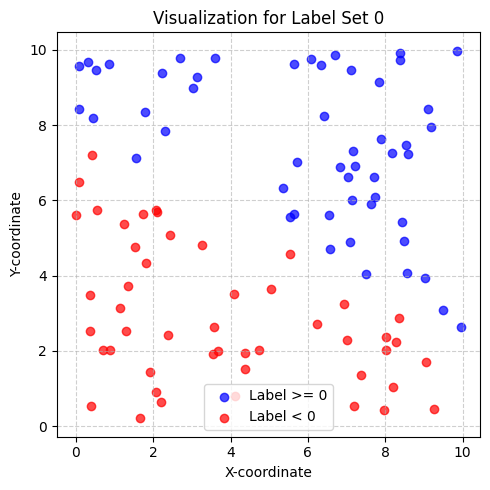

In [ ]:
points1, labels1 = generate_dataset(100, (0, 10), [lambda x, y: (y > 0.5 * x + 2.5) * 2 - 1])
points2, labels2 = generate_dataset(100, (0, 10), [lambda x, y: (y > -0.5 * x + 7.5) * 2 - 1])

plot_points(points1, labels1)
plot_points(points2, labels2)

Train on the first and display the predictions like before.

Moore Penrose loss: 0.26
Gradient Descent loss: 0.27


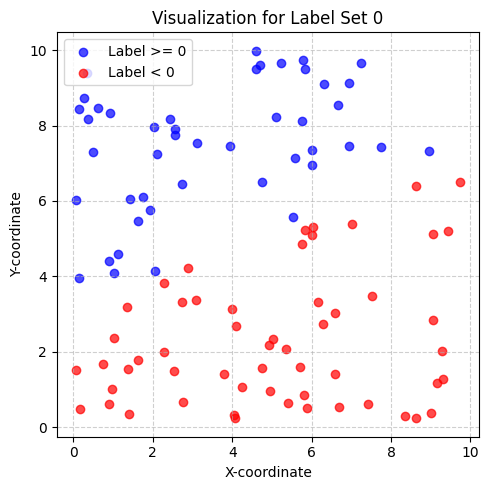

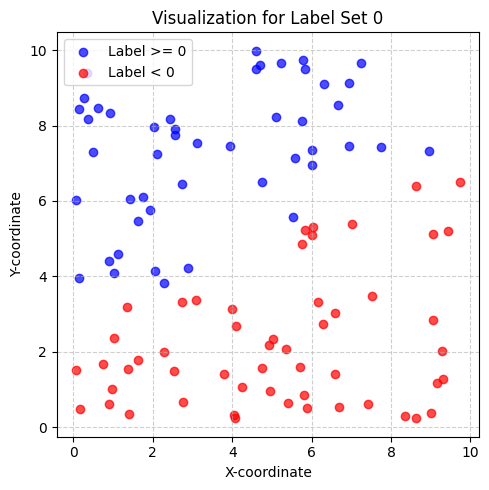

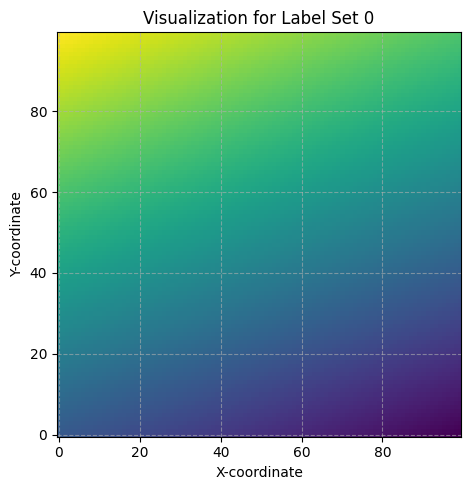

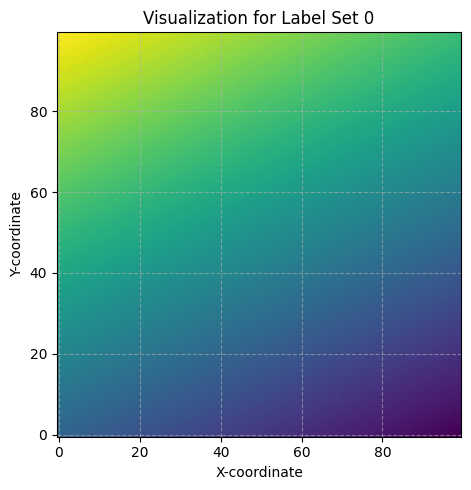

In [ ]:
mpi_W, loss, A, B = mpi_fit(points1, labels1)
gd_W, losses = gd_fit(points1, labels1, 1000, 0.01)
print(f"Moore Penrose loss: {loss:.2f}\nGradient Descent loss: {losses[-1]:.2f}")

mpi_Y = pred(mpi_W, points1)
gd_Y = pred(gd_W, points1)

plot_points(points1, mpi_Y)
plot_points(points1, gd_Y)

plot_space(mpi_W, 10, 100)
plot_space(gd_W, 10, 100)

Moore Penrose loss: 0.38
Gradient Descent loss: 0.30


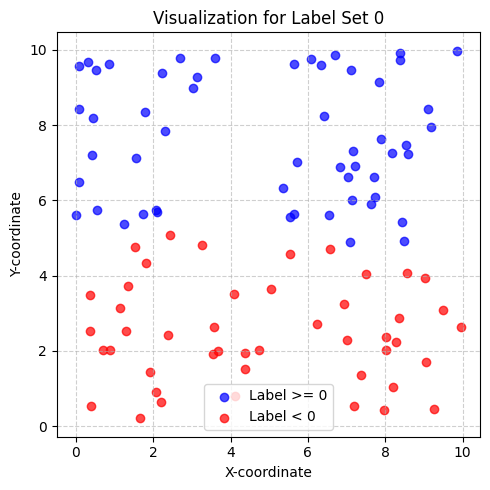

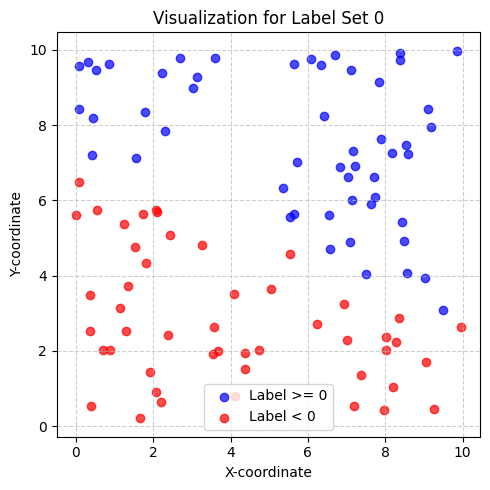

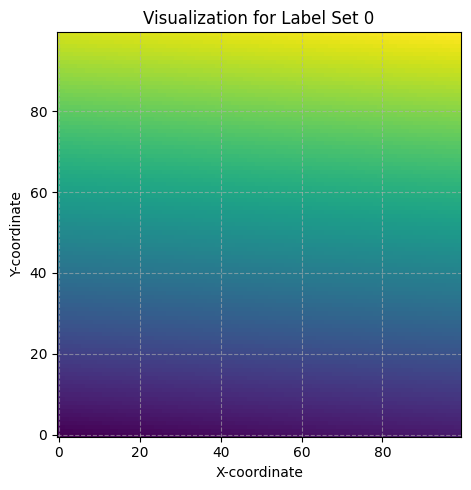

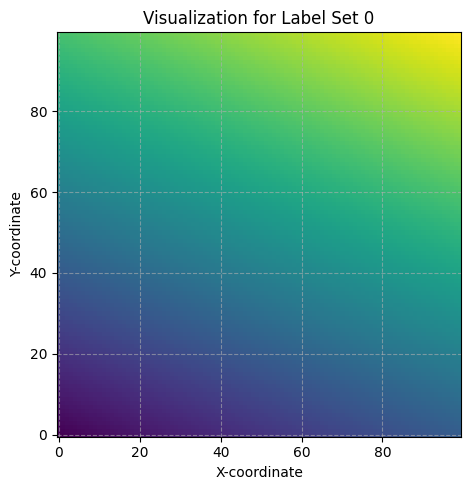

In [ ]:

mpi_W, loss, A, B = mpi_fit(points2, labels2, A=A, B=B)
gd_W, losses = gd_fit(points2, labels2, 1000, 0.01, gd_W)
print(f"Moore Penrose loss: {loss:.2f}\nGradient Descent loss: {losses[-1]:.2f}")

mpi_Y = pred(mpi_W, points2)
gd_Y = pred(gd_W, points2)

plot_points(points2, mpi_Y)
plot_points(points2, gd_Y)

plot_space(mpi_W, 10, 100)
plot_space(gd_W, 10, 100)

Next step is to do some tests with the memory state calculation from model.py. First import model as mm and torch as pt.

In [ ]:
import model as mm
import torch as pt

Now for the first test, create a dataset that appears as a single batch of k and v vectors, and give a weight of 1, and receptance of 1.

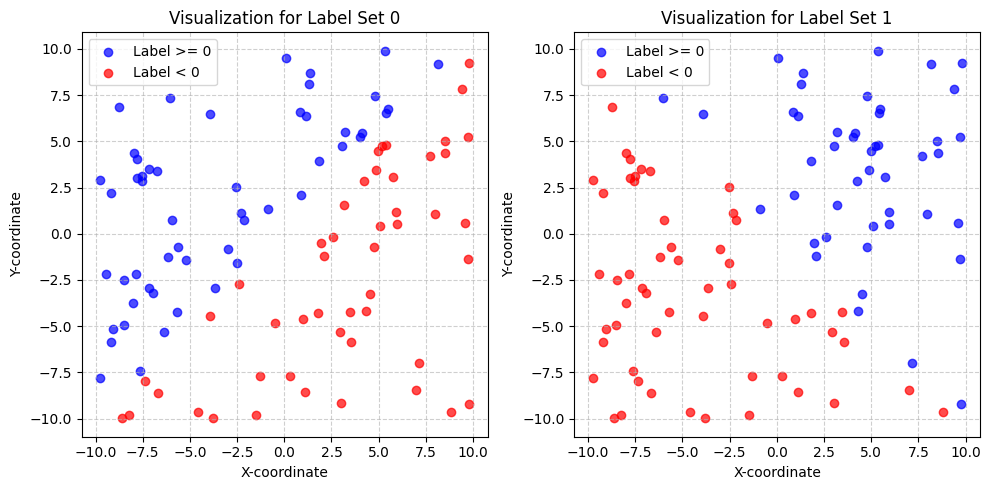

In [23]:
raw_k, raw_v = generate_dataset(100, (-10, 10), [
    lambda x, y: (y > x) * 2 - 1,
    lambda x, y: (y > -x) * 2 - 1,
    ])

k = pt.tensor(raw_k[None, ...], dtype=pt.float32)
v = pt.tensor(raw_v[None, ...], dtype=pt.float32)

r = pt.full((1, 100, 4), 0.1, dtype=pt.float32)

plot_points(raw_k, raw_v)

Next to calculate the memory matrices using the simulated kvrw values.

Memory shape: torch.Size([1, 100, 2, 2])
A shape: torch.Size([1, 100, 2, 2])
B shape: torch.Size([1, 100, 2, 2])


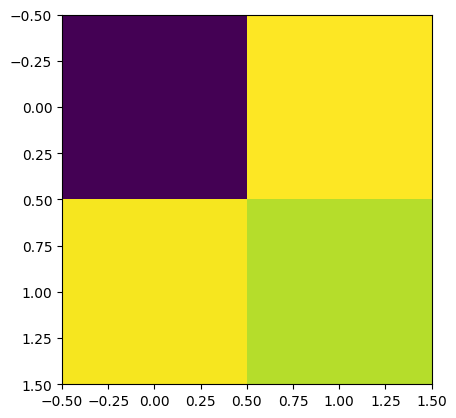

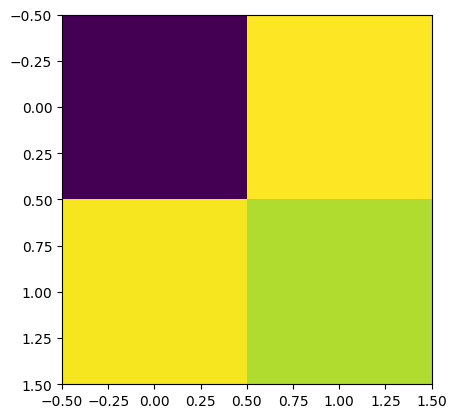

Memory A:
 [[23.456715   6.1301727]
 [ 6.1301727 19.834404 ]]
MPI A:
 [[3669.67010893  934.537487  ]
 [ 934.537487   3070.65217507]]
Memory B:
 [[-2.1752093  1.3251742]
 [ 2.8545117  2.1805449]]
MPI B:
 [[-336.15877991  448.33541534]
 [ 212.5856575   336.2049692 ]]


In [24]:
memory, A, B, C, predloss = mm.get_mem(k, v, r)
print(f"Memory shape: {memory.shape}")
print(f"A shape: {A.shape}")
print(f"B shape: {B.shape}")

ref_mpi_W, _, ref_A, ref_B = mpi_fit(raw_k, raw_v, bias=False)

mem_W = memory[0, -1].numpy()
mem_A = A[0, -1].numpy()
mem_B = B[0, -1].numpy()
plt.imshow(mem_W)
plt.show()

plt.imshow(ref_mpi_W)
plt.show()

print("Memory A:\n", mem_A)
print("MPI A:\n", ref_A)
print("Memory B:\n", mem_B)
print("MPI B:\n", ref_B)

Now to test the final matrix on the original dataset and visualize results.

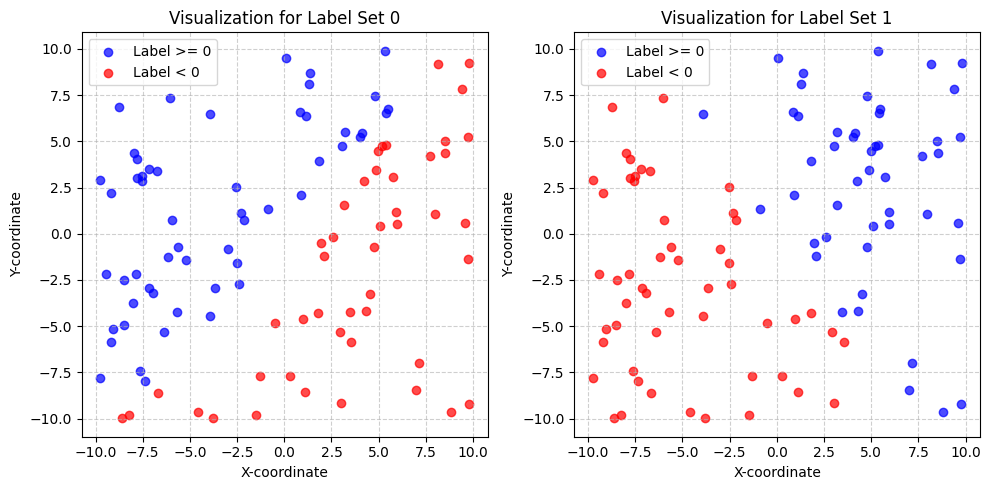

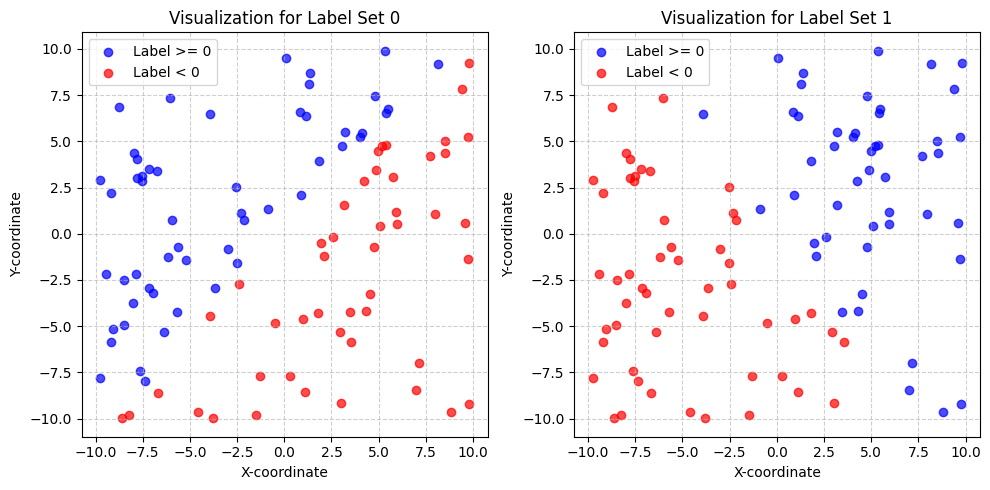

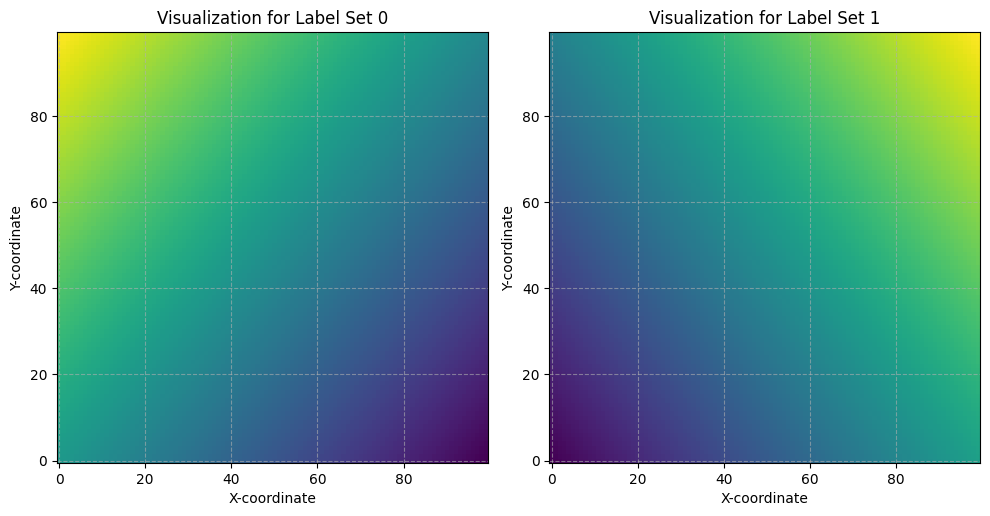

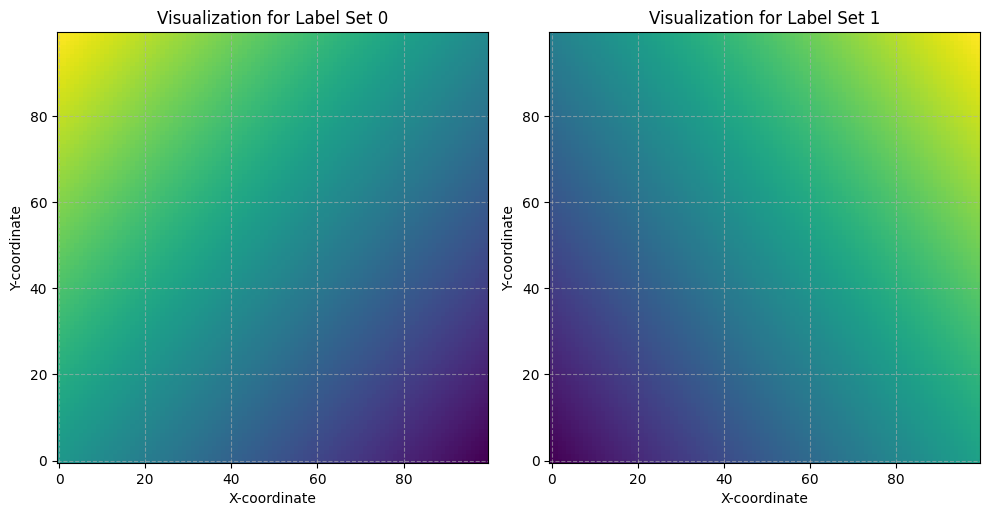

In [25]:
mem_Y = pred(mem_W, raw_k, bias=False)
ref_Y = pred(ref_mpi_W, raw_k, bias=False)

plot_points(raw_k, mem_Y)
plot_points(raw_k, ref_Y)

plot_space(mem_W, 10, 100, bias=False)
plot_space(ref_mpi_W, 10, 100, bias=False)

Now to test differentiability, I will try training key value pairs as my tunable parameters, to optimize for a second dataset of equivalent linear separation. First I need to import some more torch utils.

In [ ]:
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

from tqdm import tqdm

Now to make the datasets and parameters. Also making the criterion and optimizer while I'm at it.

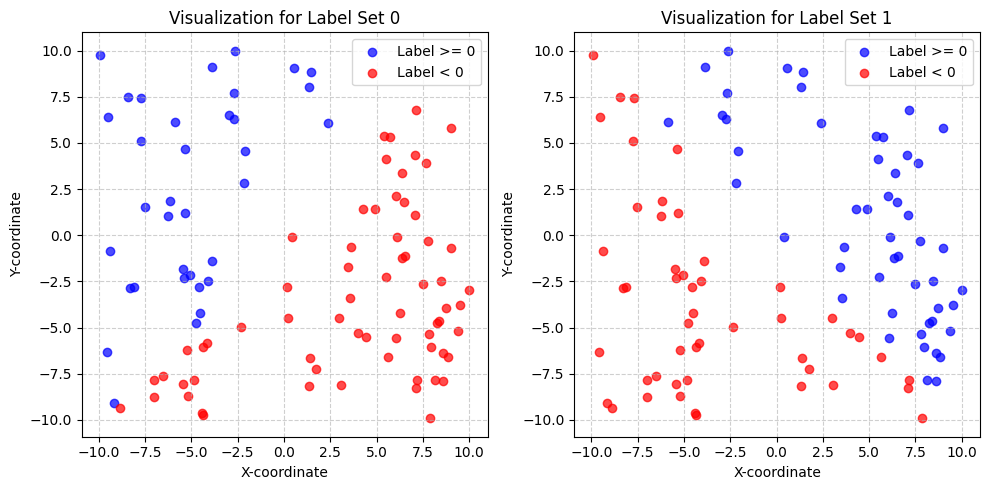

dataset length: 100
number of batches: 13


In [26]:
raw_q, raw_y = generate_dataset(100, (-10, 10), [
    lambda x, y: (y > x) * 2 - 1,
    lambda x, y: (y > -x) * 2 - 1,
    ])

plot_points(raw_q, raw_y)

raw_k = pt.randn(1, 32, 2, dtype=pt.float32)
raw_v = pt.randn(1, 32, 2, dtype=pt.float32)
k = nn.Parameter(raw_k.clone())
v = nn.Parameter(raw_v.clone())

r = pt.full((1, 100, 4), 0.1, dtype=pt.float32)

q = pt.tensor(raw_q, dtype=pt.float32)
y = pt.tensor(raw_y, dtype=pt.float32)

qy_dataset = TensorDataset(q, y)
qy_dataloader = DataLoader(qy_dataset, batch_size=8, shuffle=True)
print(f"dataset length: {len(qy_dataset)}\nnumber of batches: {len(qy_dataloader)}")

criterion = nn.MSELoss()
optimizer = optim.AdamW([k, v], lr=1e-3)

Now quickly visualize the first mem_W that would be generated by the random intial weights.

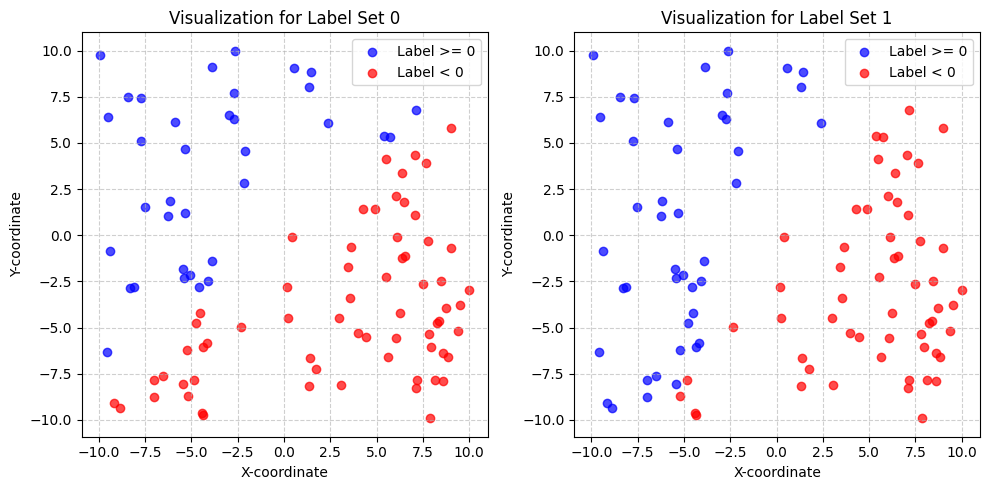

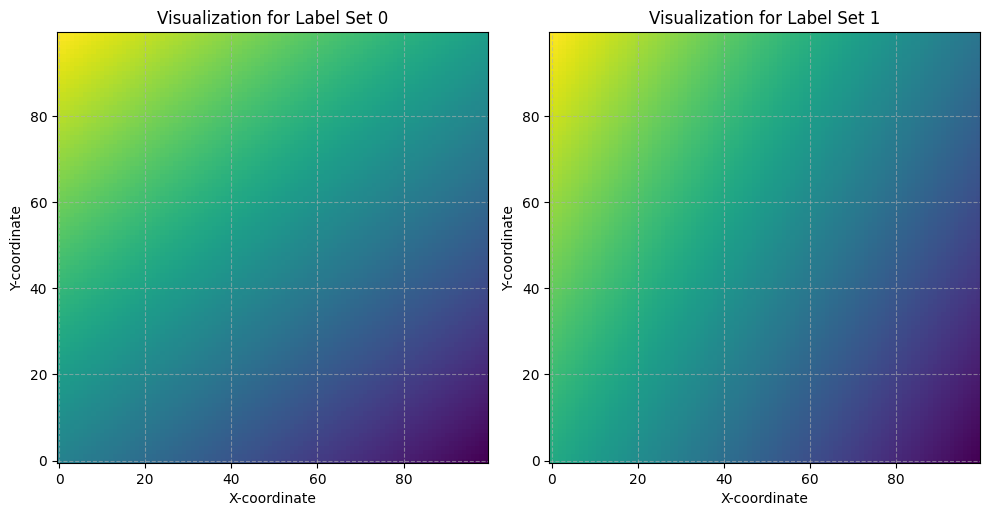

In [27]:
memory, A, B, C, predloss = mm.get_mem(k, v, r)
mem_W = memory[0, -1].detach().numpy()

pred_Y = pred(mem_W, raw_q, bias=False)
plot_points(raw_q, pred_Y)
plot_space(mem_W, 10, 100, bias=False)

Now to train.

100%|██████████| 100/100 [00:22<00:00,  4.38it/s, loss=0.3153, lr=0.001]

CoLoss: 0.2981332540512085


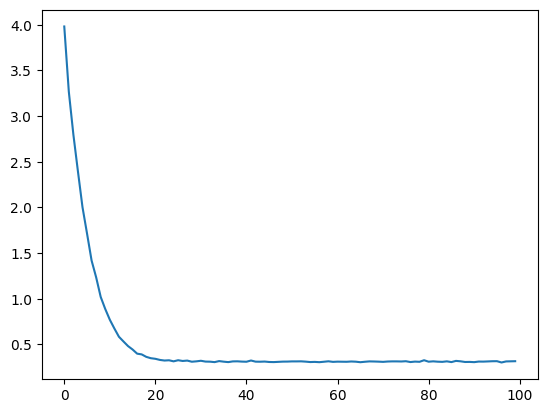

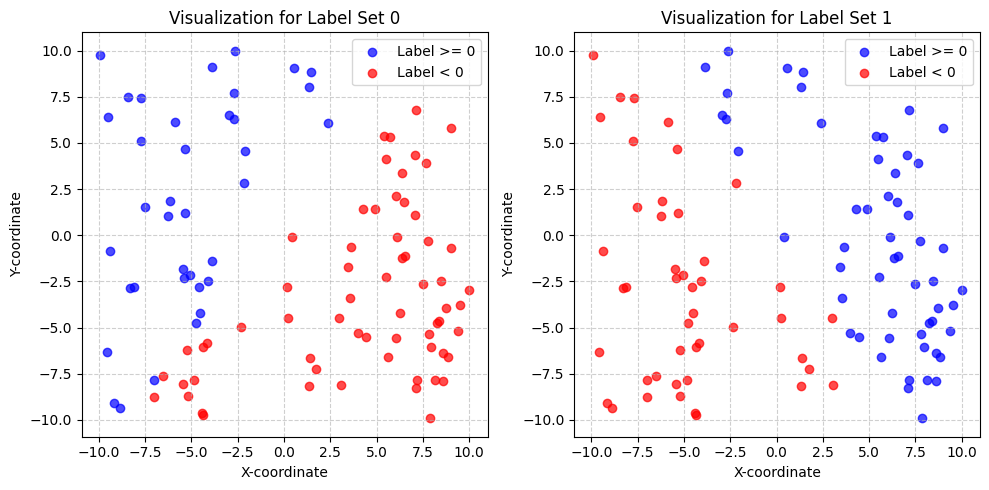

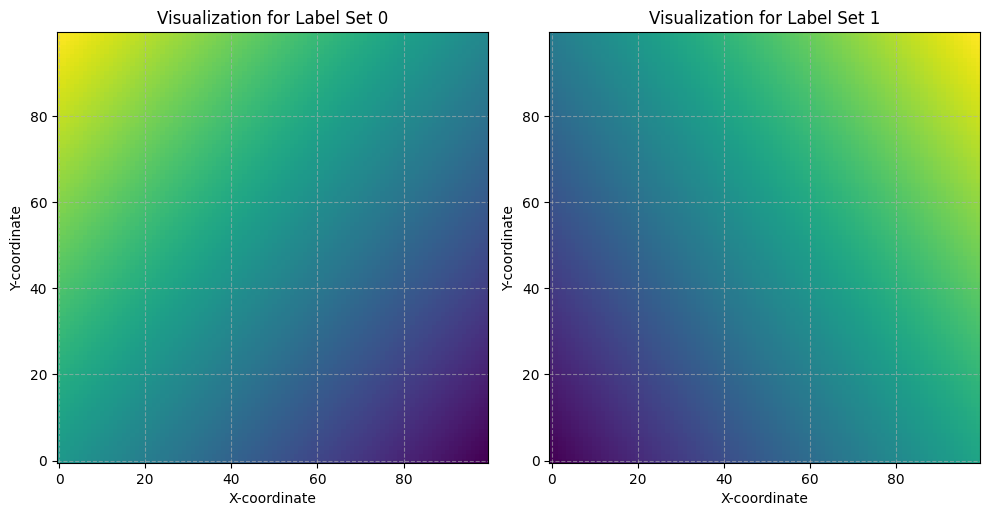

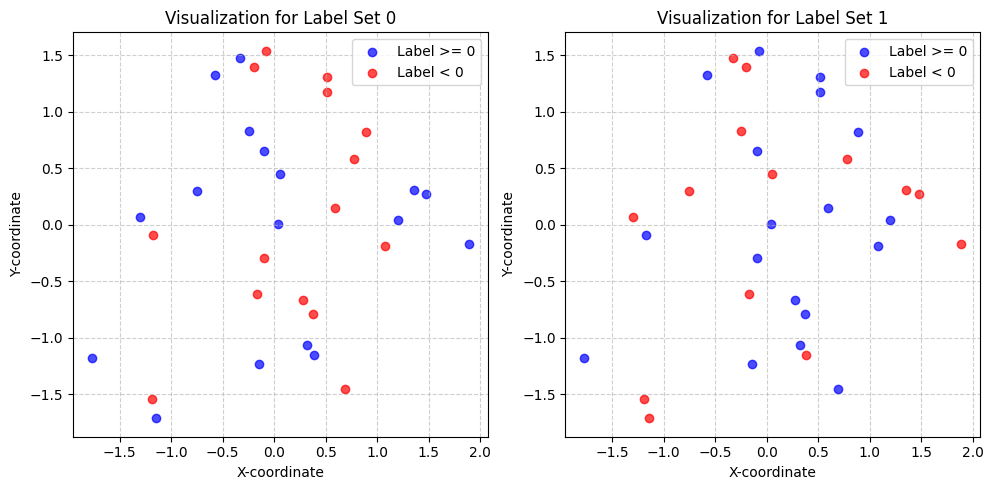

In [28]:
with pt.no_grad():
    k[:] = raw_k
    v[:] = raw_v

losses = []
pbar = tqdm(range(100))
for epoch in pbar:
    total_loss = 0
    for q, y in qy_dataloader:
        optimizer.zero_grad()

        memory, A, B, C, predloss = mm.get_mem(k, v, r)
        mem_W = memory[0, -1]
        pred_y = q @ mem_W.T

        loss = criterion(pred_y, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(qy_dataloader)
    losses.append(avg_loss)
    current_lr = optimizer.param_groups[0]['lr']
    pbar.set_postfix(loss=f"{avg_loss:.4f}", lr=current_lr)

print(f"CoLoss: {predloss}")

plt.plot(losses)
plt.show()

mem_W = mem_W.detach().numpy()
pred_Y = pred(mem_W, raw_q, bias=False)
plot_points(raw_q, pred_Y)
plot_space(mem_W, 10, 100, bias=False)

plot_points(k[0].detach().numpy(), v[0].detach().numpy())

Therefore since the get_mem function is trainable it seems like it should work in the attention mechanism. However, looking at the keys and values, the embeddings do not appear to be very meaningful. One way to work around this is to maybe also optimize for the weight's loss for the keys and values. So now I will try adding MSE for the kv pairs and seeing how that affects the kv embeddings.

100%|██████████| 500/500 [02:27<00:00,  3.39it/s, CL=0.1639, MCL=0.0554, loss=0.4781, lr=0.001]

CoLoss: 0.1638751052893125
MSE CoLoss: 0.055374497977586895


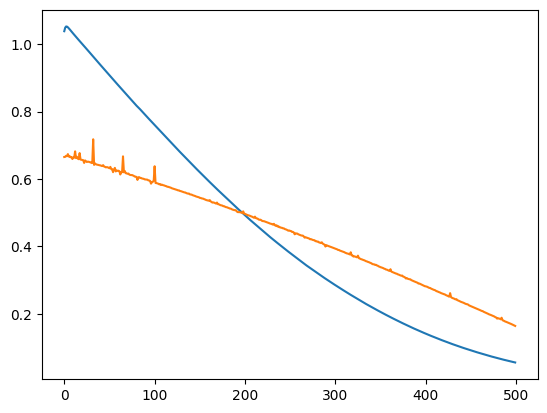

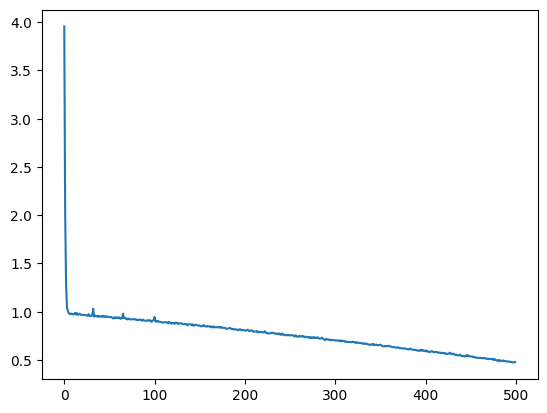

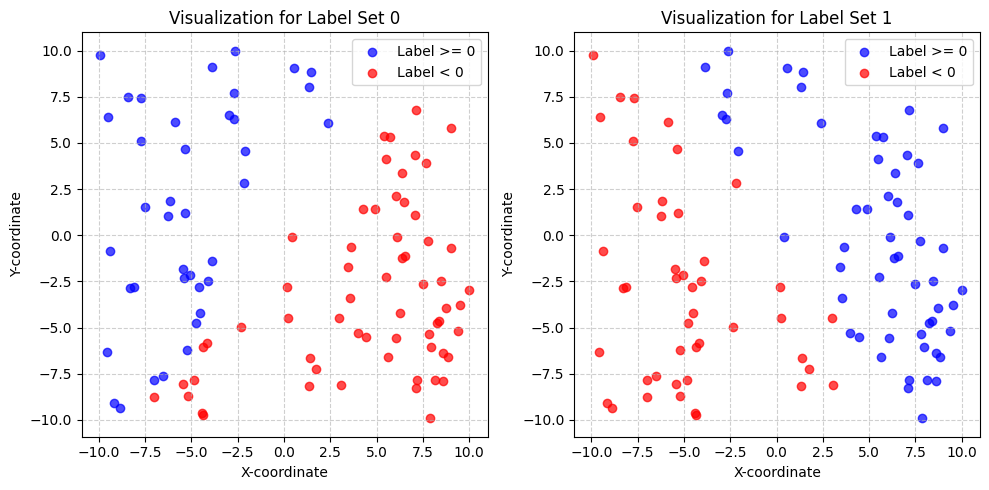

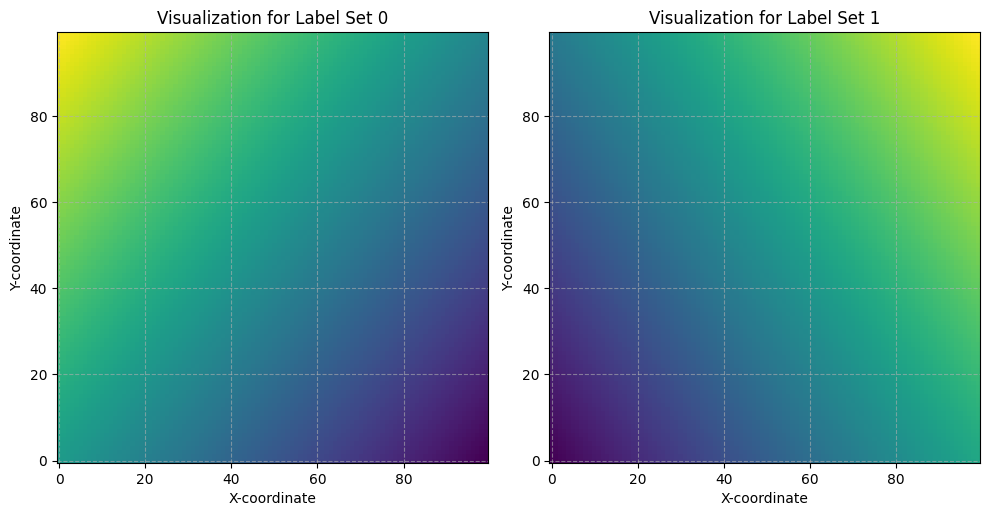

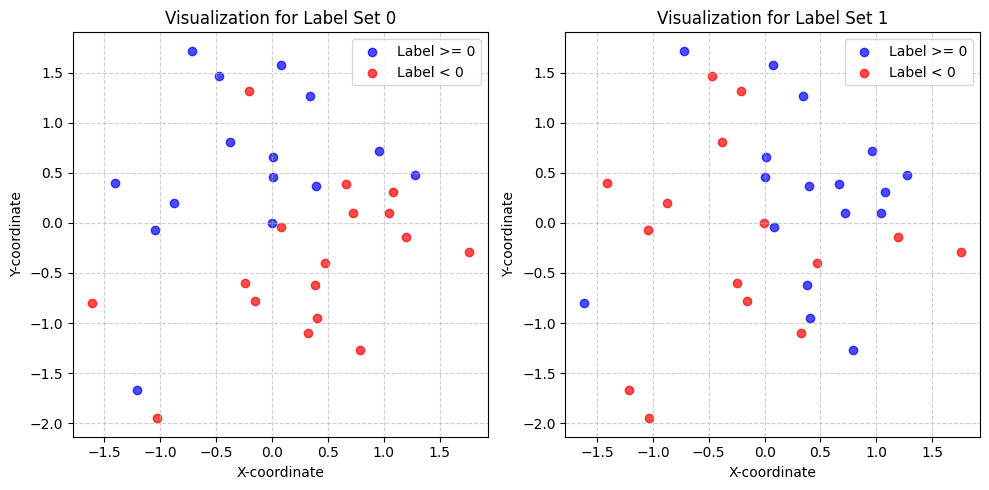

In [33]:
#optimizer.param_groups[0]["lr"] *= 0.1
with pt.no_grad():
    k[:] = raw_k
    v[:] = raw_v

losses = []
mse_colosses = []
predlosses = []
pbar = tqdm(range(500))
for epoch in pbar:
    total_loss = 0
    total_mse_coloss = 0
    total_predloss = 0
    for q, y in qy_dataloader:
        optimizer.zero_grad()

        memory, A, B, C, predloss = mm.get_mem(k, v, r)
        #predloss /= k.shape[1]
        predloss **= 1 / 3
        mem_W = memory[0, -1]
        pred_y = q @ mem_W.T
        pred_v = k[0] @ mem_W.T

        mse_loss = criterion(pred_y, y)
        mse_coloss = criterion(pred_v, v[0])
        #loss = criterion(pred_y, y) + mse_coloss
        loss = mse_loss + predloss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_mse_coloss += mse_coloss.item()
        total_predloss += predloss.item()

    avg_loss = total_loss / len(qy_dataloader)
    avg_mse_coloss = total_mse_coloss / len(qy_dataloader)
    avg_predloss = total_predloss / len(qy_dataloader)
    losses.append(avg_loss)
    mse_colosses.append(avg_mse_coloss)
    predlosses.append(avg_predloss)
    current_lr = optimizer.param_groups[0]['lr']
    pbar.set_postfix(loss=f"{avg_loss:.4f}", lr=current_lr, CL=f"{avg_predloss:.4f}", MCL=f"{avg_mse_coloss:.4f}")

print(f"CoLoss: {avg_predloss}")
print(f"MSE CoLoss: {avg_mse_coloss}")

plt.plot(mse_colosses)
plt.plot(predlosses)
plt.show()

plt.plot(losses)
plt.show()

mem_W = mem_W.detach().numpy()
pred_Y = pred(mem_W, raw_q, bias=False)
plot_points(raw_q, pred_Y)
plot_space(mem_W, 10, 100, bias=False)

plot_points(k[0].detach().numpy(), v[0].detach().numpy())

With this modified loss function we can see that the keys align more with the queries and the values align more with the retrieved values. Hence, these kv embeddings are now more meaningful. The next step is to find a way to accomplish this effect taking into account each timestep's memory matrix, the weight and receptance, and varying query objectives without significantly more loss computations.

One possible method to ensure that the model is correctly using the kv embeddings to steer the memory matrix is to check the MSE for the kv embeddings with their updated weight matrix. To better simulate real conditions I will now also make r and w parameters, and add a changing query objective. I think the qy MSE loss should nudge memory matrix in the right direction, and the kv MSE loss should nudge the kv prediction in the right direction to produce the memory matrix. In summary qy MSE optimizes retrieval and kv MSE optimizes storage.

Returning back to the original mpi_fit test I am now going to try to calculate the MSE by adding a covariance matrix for Y.
